# ECE9063 Project

Hyperparameters
-
- number of features extraction layers
- number of filters
- filter size
- dense layer units
- batch size
- learning rate
- epochs
- kernel regularizer
- dropout

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Cropped head image 50x50x3

In [3]:
folder_path = 'Data/images/cropped_50'
image_size = (50, 50)

In [4]:
def load_data_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        label = 1 if filename.endswith('T.png') else 0  # 1 for 'T' (with helmet), 0 for 'F' (without helmet)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [6]:
print(X_train.shape)
print(X_test.shape)

(556, 50, 50, 3)
(140, 50, 50, 3)


In [6]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

model.save('helmet_detection_model.keras')

Epoch 1/50
18/18 [==============================] - 2s 83ms/step - loss: 10.7061 - accuracy: 0.6727 - val_loss: 0.8937 - val_accuracy: 0.7857
Epoch 2/50
18/18 [==============================] - 1s 70ms/step - loss: 0.4981 - accuracy: 0.8040 - val_loss: 0.4187 - val_accuracy: 0.7857
Epoch 3/50
18/18 [==============================] - 1s 71ms/step - loss: 0.3661 - accuracy: 0.8219 - val_loss: 0.3800 - val_accuracy: 0.8571
Epoch 4/50
18/18 [==============================] - 1s 78ms/step - loss: 0.3152 - accuracy: 0.8615 - val_loss: 0.3877 - val_accuracy: 0.8000
Epoch 5/50
18/18 [==============================] - 1s 73ms/step - loss: 0.2897 - accuracy: 0.8579 - val_loss: 0.3427 - val_accuracy: 0.8857
Epoch 6/50
18/18 [==============================] - 1s 78ms/step - loss: 0.1801 - accuracy: 0.9353 - val_loss: 0.2631 - val_accuracy: 0.8857
Epoch 7/50
18/18 [==============================] - 1s 82ms/step - loss: 0.1084 - accuracy: 0.9586 - val_loss: 0.2599 - val_accuracy: 0.8929
Epoch 8/50
1

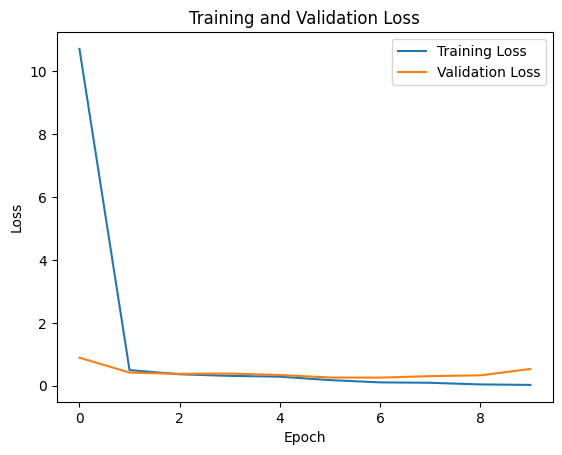

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Auto Hyperparameter tuning

In [8]:
import optuna

C:\Users\WHR\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def create_cnn_model(trial):
    model = Sequential()
    model.add(Conv2D(filters=trial.suggest_int('fileters',16,128,log=True), kernel_size=(5,5), activation='relu', input_shape=(50, 50, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=trial.suggest_int('fileters',16,128,log=True), kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=trial.suggest_int('fileters',16,128,log=True), kernel_size=(5,5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=trial.suggest_int('units',32,256,log=True), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
def objective(trial):
    model = create_cnn_model(trial)
    model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    score = model.evaluate(X_test,y_test,verbose=0)
    return score[1]

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_trial = study.best_trial
print(f"Best trial - Accuracy: {best_trial.value:.4f}, Parameters: {best_trial.params}")

[I 2023-11-18 21:09:34,574] A new study created in memory with name: no-name-7f31b156-4d81-42a9-ae0d-be9611deea76
[I 2023-11-18 21:10:30,663] Trial 0 finished with value: 0.8857142925262451 and parameters: {'fileters': 95, 'units': 107}. Best is trial 0 with value: 0.8857142925262451.
[I 2023-11-18 21:10:39,478] Trial 1 finished with value: 0.8500000238418579 and parameters: {'fileters': 33, 'units': 71}. Best is trial 0 with value: 0.8857142925262451.
[I 2023-11-18 21:10:52,190] Trial 2 finished with value: 0.9071428775787354 and parameters: {'fileters': 53, 'units': 36}. Best is trial 2 with value: 0.9071428775787354.
[I 2023-11-18 21:11:14,976] Trial 3 finished with value: 0.8857142925262451 and parameters: {'fileters': 89, 'units': 222}. Best is trial 2 with value: 0.9071428775787354.
[I 2023-11-18 21:11:24,658] Trial 4 finished with value: 0.8785714507102966 and parameters: {'fileters': 29, 'units': 32}. Best is trial 2 with value: 0.9071428775787354.
[I 2023-11-18 21:11:39,146] T

Best trial - Accuracy: 0.9357, Parameters: {'fileters': 85, 'units': 58}


## Customized hyperparameters

In [64]:
def cust_hyper_cnn(filter,unit,ksize,lrate,num_of_layers):
    model = Sequential()
    model.add(Conv2D(filter, (ksize, ksize), activation='relu', input_shape=(50, 50, 3)))
    for i in range(num_of_layers):
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(filter, (ksize, ksize), activation='relu'))
    model.add(Flatten())
    model.add(Dense(unit, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lrate), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [65]:
cust_hyper_cnn(85,58,5,0.001,2)

Epoch 1/100
18/18 [==============================] - 2s 105ms/step - loss: 10.1654 - accuracy: 0.6529 - val_loss: 0.5227 - val_accuracy: 0.7857
Epoch 2/100
18/18 [==============================] - 2s 93ms/step - loss: 0.4066 - accuracy: 0.8094 - val_loss: 0.4413 - val_accuracy: 0.7857
Epoch 3/100
18/18 [==============================] - 2s 92ms/step - loss: 0.3819 - accuracy: 0.8219 - val_loss: 0.4145 - val_accuracy: 0.7857
Epoch 4/100
18/18 [==============================] - 2s 94ms/step - loss: 0.3436 - accuracy: 0.8345 - val_loss: 0.3213 - val_accuracy: 0.9214
Epoch 5/100
18/18 [==============================] - 2s 94ms/step - loss: 0.2840 - accuracy: 0.8903 - val_loss: 0.3057 - val_accuracy: 0.8786
Epoch 6/100
18/18 [==============================] - 2s 100ms/step - loss: 0.2280 - accuracy: 0.8993 - val_loss: 0.4610 - val_accuracy: 0.8286
Epoch 7/100
18/18 [==============================] - 2s 101ms/step - loss: 0.2519 - accuracy: 0.8921 - val_loss: 0.3289 - val_accuracy: 0.8571
Ep

In [66]:
cust_hyper_cnn(85,58,3,0.001,2)

Epoch 1/100
18/18 [==============================] - 2s 81ms/step - loss: 6.1886 - accuracy: 0.7248 - val_loss: 0.5939 - val_accuracy: 0.8143
Epoch 2/100
18/18 [==============================] - 1s 79ms/step - loss: 0.3860 - accuracy: 0.8435 - val_loss: 0.4406 - val_accuracy: 0.8357
Epoch 3/100
18/18 [==============================] - 2s 85ms/step - loss: 0.2996 - accuracy: 0.8705 - val_loss: 0.3151 - val_accuracy: 0.8643
Epoch 4/100
18/18 [==============================] - 2s 96ms/step - loss: 0.2694 - accuracy: 0.8849 - val_loss: 0.2440 - val_accuracy: 0.8857
Epoch 5/100
18/18 [==============================] - 2s 96ms/step - loss: 0.2501 - accuracy: 0.8885 - val_loss: 0.3080 - val_accuracy: 0.8786
Epoch 6/100
18/18 [==============================] - 2s 92ms/step - loss: 0.1822 - accuracy: 0.9281 - val_loss: 0.2796 - val_accuracy: 0.8929
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2440 - accuracy: 0.8857
Test Accuracy: 88.57%


In [67]:
cust_hyper_cnn(85,58,3,0.0001,2)

Epoch 1/100
18/18 [==============================] - 2s 97ms/step - loss: 2.8397 - accuracy: 0.7140 - val_loss: 1.0442 - val_accuracy: 0.7857
Epoch 2/100
18/18 [==============================] - 2s 95ms/step - loss: 0.6279 - accuracy: 0.8255 - val_loss: 0.4246 - val_accuracy: 0.8429
Epoch 3/100
18/18 [==============================] - 2s 92ms/step - loss: 0.3811 - accuracy: 0.8687 - val_loss: 0.4792 - val_accuracy: 0.8143
Epoch 4/100
18/18 [==============================] - 2s 93ms/step - loss: 0.2621 - accuracy: 0.8903 - val_loss: 0.5686 - val_accuracy: 0.7929
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 0.4246 - accuracy: 0.8429
Test Accuracy: 84.29%


In [68]:
cust_hyper_cnn(85,58,3,0.001,3)

Epoch 1/100
18/18 [==============================] - 2s 95ms/step - loss: 0.9248 - accuracy: 0.7626 - val_loss: 0.5025 - val_accuracy: 0.7500
Epoch 2/100
18/18 [==============================] - 2s 90ms/step - loss: 0.3650 - accuracy: 0.8417 - val_loss: 0.2995 - val_accuracy: 0.8714
Epoch 3/100
18/18 [==============================] - 2s 90ms/step - loss: 0.3108 - accuracy: 0.8669 - val_loss: 0.2939 - val_accuracy: 0.8786
Epoch 4/100
18/18 [==============================] - 2s 91ms/step - loss: 0.2325 - accuracy: 0.8993 - val_loss: 0.3041 - val_accuracy: 0.9143
Epoch 5/100
18/18 [==============================] - 2s 90ms/step - loss: 0.1868 - accuracy: 0.9299 - val_loss: 0.2731 - val_accuracy: 0.9357
Epoch 6/100
18/18 [==============================] - 2s 90ms/step - loss: 0.1504 - accuracy: 0.9371 - val_loss: 0.2798 - val_accuracy: 0.9071
Epoch 7/100
18/18 [==============================] - 2s 91ms/step - loss: 0.1039 - accuracy: 0.9676 - val_loss: 0.3830 - val_accuracy: 0.9143
Epoch 

In [69]:
cust_hyper_cnn(85,58,3,0.001,1)

Epoch 1/100
18/18 [==============================] - 2s 96ms/step - loss: 28.7766 - accuracy: 0.7698 - val_loss: 0.4351 - val_accuracy: 0.8143
Epoch 2/100
18/18 [==============================] - 2s 89ms/step - loss: 0.3356 - accuracy: 0.8597 - val_loss: 0.6370 - val_accuracy: 0.8357
Epoch 3/100
18/18 [==============================] - 2s 90ms/step - loss: 0.4268 - accuracy: 0.9083 - val_loss: 0.4746 - val_accuracy: 0.8286
Epoch 4/100
5/5 [==============================] - 0s 24ms/step - loss: 0.4351 - accuracy: 0.8143
Test Accuracy: 81.43%


In [70]:
cust_hyper_cnn(85,58,7,0.001,2)

Epoch 1/100
18/18 [==============================] - 4s 182ms/step - loss: 10.5341 - accuracy: 0.7374 - val_loss: 0.4088 - val_accuracy: 0.8000
Epoch 2/100
18/18 [==============================] - 3s 177ms/step - loss: 0.3631 - accuracy: 0.8399 - val_loss: 0.3731 - val_accuracy: 0.8357
Epoch 3/100
18/18 [==============================] - 3s 175ms/step - loss: 0.3336 - accuracy: 0.8723 - val_loss: 0.3729 - val_accuracy: 0.8357
Epoch 4/100
18/18 [==============================] - 3s 174ms/step - loss: 0.3129 - accuracy: 0.8705 - val_loss: 0.3701 - val_accuracy: 0.8500
Epoch 5/100
18/18 [==============================] - 3s 176ms/step - loss: 0.2386 - accuracy: 0.9011 - val_loss: 0.4464 - val_accuracy: 0.8429
Epoch 6/100
18/18 [==============================] - 3s 174ms/step - loss: 0.1950 - accuracy: 0.9191 - val_loss: 0.4550 - val_accuracy: 0.8071
Epoch 7/100
5/5 [==============================] - 0s 36ms/step - loss: 0.3701 - accuracy: 0.8500
Test Accuracy: 85.00%


In [71]:
cust_hyper_cnn(85,58,5,0.01,2)

Epoch 1/100
18/18 [==============================] - 3s 133ms/step - loss: 872.5471 - accuracy: 0.7266 - val_loss: 0.5298 - val_accuracy: 0.7857
Epoch 2/100
18/18 [==============================] - 2s 128ms/step - loss: 0.5110 - accuracy: 0.8094 - val_loss: 10.2183 - val_accuracy: 0.7857
Epoch 3/100
18/18 [==============================] - 2s 135ms/step - loss: 1.5641 - accuracy: 0.8076 - val_loss: 0.5235 - val_accuracy: 0.7857
Epoch 4/100
18/18 [==============================] - 2s 133ms/step - loss: 0.4884 - accuracy: 0.8094 - val_loss: 0.5199 - val_accuracy: 0.7857
Epoch 5/100
18/18 [==============================] - 2s 132ms/step - loss: 0.4895 - accuracy: 0.8094 - val_loss: 0.5302 - val_accuracy: 0.7857
Epoch 6/100
18/18 [==============================] - 2s 134ms/step - loss: 0.4914 - accuracy: 0.8094 - val_loss: 0.5245 - val_accuracy: 0.7857
Epoch 7/100
18/18 [==============================] - 2s 131ms/step - loss: 0.4953 - accuracy: 0.8094 - val_loss: 0.5193 - val_accuracy: 0.7

In [72]:
cust_hyper_cnn(85,58,5,0.0001,2)

Epoch 1/100
18/18 [==============================] - 3s 144ms/step - loss: 1.8821 - accuracy: 0.7374 - val_loss: 1.2060 - val_accuracy: 0.7714
Epoch 2/100
18/18 [==============================] - 3s 143ms/step - loss: 0.6875 - accuracy: 0.8471 - val_loss: 0.4513 - val_accuracy: 0.8143
Epoch 3/100
18/18 [==============================] - 2s 139ms/step - loss: 0.3109 - accuracy: 0.8669 - val_loss: 0.3662 - val_accuracy: 0.8571
Epoch 4/100
18/18 [==============================] - 3s 142ms/step - loss: 0.2076 - accuracy: 0.9263 - val_loss: 0.4876 - val_accuracy: 0.8214
Epoch 5/100
18/18 [==============================] - 3s 140ms/step - loss: 0.1711 - accuracy: 0.9353 - val_loss: 0.2535 - val_accuracy: 0.9071
Epoch 6/100
18/18 [==============================] - 3s 141ms/step - loss: 0.1293 - accuracy: 0.9478 - val_loss: 0.2913 - val_accuracy: 0.9143
Epoch 7/100
18/18 [==============================] - 3s 143ms/step - loss: 0.1176 - accuracy: 0.9604 - val_loss: 0.3099 - val_accuracy: 0.9000

## Dropout

In [73]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

In [81]:
def cust_hyper_cnn_rd(filter,unit,ksize,lrate,num_of_layers,reg,dropout,bs):
    model = Sequential()
    model.add(Conv2D(filter, (ksize, ksize), activation='relu', input_shape=(50, 50, 3)))
    for i in range(num_of_layers):
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(filter, (ksize, ksize), activation='relu', kernel_regularizer=l2(reg)))
        model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(unit, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lrate), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=bs, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [82]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.01,0.05, 32)

Epoch 1/100
18/18 [==============================] - 3s 115ms/step - loss: 6.8760 - accuracy: 0.6817 - val_loss: 1.9774 - val_accuracy: 0.7500
Epoch 2/100
18/18 [==============================] - 2s 109ms/step - loss: 1.9628 - accuracy: 0.7932 - val_loss: 1.8457 - val_accuracy: 0.7786
Epoch 3/100
18/18 [==============================] - 3s 163ms/step - loss: 1.7738 - accuracy: 0.8112 - val_loss: 1.7369 - val_accuracy: 0.7714
Epoch 4/100
18/18 [==============================] - 3s 165ms/step - loss: 1.6721 - accuracy: 0.8255 - val_loss: 1.6099 - val_accuracy: 0.7929
Epoch 5/100
18/18 [==============================] - 3s 163ms/step - loss: 1.5763 - accuracy: 0.8435 - val_loss: 1.6180 - val_accuracy: 0.8286
Epoch 6/100
18/18 [==============================] - 3s 161ms/step - loss: 1.4994 - accuracy: 0.8417 - val_loss: 1.5295 - val_accuracy: 0.7857
Epoch 7/100
18/18 [==============================] - 3s 159ms/step - loss: 1.4638 - accuracy: 0.8507 - val_loss: 1.4277 - val_accuracy: 0.8429

In [83]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.0,0.05, 32)

Epoch 1/100
18/18 [==============================] - 4s 158ms/step - loss: 3.8529 - accuracy: 0.7536 - val_loss: 0.3858 - val_accuracy: 0.7857
Epoch 2/100
18/18 [==============================] - 3s 153ms/step - loss: 0.3713 - accuracy: 0.8525 - val_loss: 0.3512 - val_accuracy: 0.8071
Epoch 3/100
18/18 [==============================] - 3s 151ms/step - loss: 0.3194 - accuracy: 0.8453 - val_loss: 0.3896 - val_accuracy: 0.7929
Epoch 4/100
18/18 [==============================] - 3s 154ms/step - loss: 0.3074 - accuracy: 0.8687 - val_loss: 0.3035 - val_accuracy: 0.9071
Epoch 5/100
18/18 [==============================] - 3s 156ms/step - loss: 0.2894 - accuracy: 0.8885 - val_loss: 0.3716 - val_accuracy: 0.8214
Epoch 6/100
18/18 [==============================] - 3s 152ms/step - loss: 0.2430 - accuracy: 0.8993 - val_loss: 0.2500 - val_accuracy: 0.9071
Epoch 7/100
18/18 [==============================] - 3s 155ms/step - loss: 0.2078 - accuracy: 0.9101 - val_loss: 0.2836 - val_accuracy: 0.9000

In [84]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.01,0.0, 32)

Epoch 1/100
18/18 [==============================] - 3s 151ms/step - loss: 11.2260 - accuracy: 0.7284 - val_loss: 1.8001 - val_accuracy: 0.8000
Epoch 2/100
18/18 [==============================] - 3s 144ms/step - loss: 1.7183 - accuracy: 0.8147 - val_loss: 1.6144 - val_accuracy: 0.8286
Epoch 3/100
18/18 [==============================] - 3s 144ms/step - loss: 1.5779 - accuracy: 0.8399 - val_loss: 1.5235 - val_accuracy: 0.8429
Epoch 4/100
18/18 [==============================] - 3s 146ms/step - loss: 1.4988 - accuracy: 0.8561 - val_loss: 1.4356 - val_accuracy: 0.8714
Epoch 5/100
18/18 [==============================] - 3s 145ms/step - loss: 1.3723 - accuracy: 0.8687 - val_loss: 1.4275 - val_accuracy: 0.8214
Epoch 6/100
18/18 [==============================] - 3s 158ms/step - loss: 1.3296 - accuracy: 0.8687 - val_loss: 1.3233 - val_accuracy: 0.8500
Epoch 7/100
18/18 [==============================] - 3s 149ms/step - loss: 1.2203 - accuracy: 0.9011 - val_loss: 1.3026 - val_accuracy: 0.857

In [85]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.01,0.1, 32)

Epoch 1/100
18/18 [==============================] - 4s 163ms/step - loss: 8.9827 - accuracy: 0.6996 - val_loss: 1.9755 - val_accuracy: 0.8214
Epoch 2/100
18/18 [==============================] - 3s 152ms/step - loss: 1.8523 - accuracy: 0.8004 - val_loss: 1.7810 - val_accuracy: 0.7857
Epoch 3/100
18/18 [==============================] - 3s 153ms/step - loss: 1.7087 - accuracy: 0.8112 - val_loss: 1.6532 - val_accuracy: 0.7929
Epoch 4/100
18/18 [==============================] - 3s 154ms/step - loss: 1.5894 - accuracy: 0.8417 - val_loss: 1.6337 - val_accuracy: 0.8357
Epoch 5/100
18/18 [==============================] - 3s 155ms/step - loss: 1.5479 - accuracy: 0.8219 - val_loss: 1.5296 - val_accuracy: 0.8500
Epoch 6/100
18/18 [==============================] - 3s 155ms/step - loss: 1.4911 - accuracy: 0.8453 - val_loss: 1.4816 - val_accuracy: 0.8500
Epoch 7/100
18/18 [==============================] - 3s 153ms/step - loss: 1.3938 - accuracy: 0.8615 - val_loss: 1.4427 - val_accuracy: 0.8929

In [86]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.1,0.25, 32)

Epoch 1/100
18/18 [==============================] - 4s 161ms/step - loss: 21.5746 - accuracy: 0.7068 - val_loss: 12.6008 - val_accuracy: 0.7857
Epoch 2/100
18/18 [==============================] - 3s 151ms/step - loss: 11.2988 - accuracy: 0.7950 - val_loss: 10.0411 - val_accuracy: 0.7857
Epoch 3/100
18/18 [==============================] - 3s 154ms/step - loss: 9.3479 - accuracy: 0.8112 - val_loss: 8.6759 - val_accuracy: 0.8071
Epoch 4/100
18/18 [==============================] - 3s 158ms/step - loss: 8.1923 - accuracy: 0.8201 - val_loss: 7.6754 - val_accuracy: 0.7929
Epoch 5/100
18/18 [==============================] - 3s 154ms/step - loss: 7.2885 - accuracy: 0.8112 - val_loss: 6.9110 - val_accuracy: 0.8643
Epoch 6/100
18/18 [==============================] - 3s 159ms/step - loss: 6.6432 - accuracy: 0.8309 - val_loss: 6.2730 - val_accuracy: 0.8000
Epoch 7/100
18/18 [==============================] - 3s 152ms/step - loss: 6.0264 - accuracy: 0.8291 - val_loss: 5.7755 - val_accuracy: 0.

In [87]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.2,0.3, 32)

Epoch 1/100
18/18 [==============================] - 4s 160ms/step - loss: 35.1182 - accuracy: 0.6888 - val_loss: 22.8573 - val_accuracy: 0.7929
Epoch 2/100
18/18 [==============================] - 3s 149ms/step - loss: 19.7945 - accuracy: 0.8112 - val_loss: 16.9614 - val_accuracy: 0.7857
Epoch 3/100
18/18 [==============================] - 3s 152ms/step - loss: 15.3834 - accuracy: 0.8076 - val_loss: 13.9460 - val_accuracy: 0.7929
Epoch 4/100
18/18 [==============================] - 3s 157ms/step - loss: 12.8428 - accuracy: 0.8147 - val_loss: 11.7784 - val_accuracy: 0.8000
Epoch 5/100
18/18 [==============================] - 3s 154ms/step - loss: 10.9199 - accuracy: 0.8094 - val_loss: 10.1332 - val_accuracy: 0.7857
Epoch 6/100
18/18 [==============================] - 3s 154ms/step - loss: 9.4401 - accuracy: 0.8273 - val_loss: 8.7571 - val_accuracy: 0.7929
Epoch 7/100
18/18 [==============================] - 3s 151ms/step - loss: 8.1941 - accuracy: 0.8345 - val_loss: 7.6285 - val_accura

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [116]:
def cust_hyper_cnn_rd(filter,unit,ksize,lrate,num_of_layers,reg,dropout,bs):
    model = Sequential()
    model.add(Conv2D(filter, (ksize, ksize), activation='relu', input_shape=(50, 50, 3)))
    for i in range(num_of_layers):
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(filter, (ksize, ksize), activation='relu', kernel_regularizer=l2(reg)))
        model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(unit, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lrate), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=bs, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    y_pred = np.round(model.predict(X_test)).astype(int)
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Without Helmet', 'With Helmet'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

Epoch 1/100
18/18 [==============================] - 3s 113ms/step - loss: 20.1715 - accuracy: 0.7266 - val_loss: 12.3637 - val_accuracy: 0.8071
Epoch 2/100
18/18 [==============================] - 2s 107ms/step - loss: 10.8415 - accuracy: 0.8022 - val_loss: 9.4464 - val_accuracy: 0.8143
Epoch 3/100
18/18 [==============================] - 2s 110ms/step - loss: 8.6642 - accuracy: 0.8273 - val_loss: 7.9000 - val_accuracy: 0.7929
Epoch 4/100
18/18 [==============================] - 2s 108ms/step - loss: 7.3955 - accuracy: 0.8273 - val_loss: 6.8754 - val_accuracy: 0.7857
Epoch 5/100
18/18 [==============================] - 2s 111ms/step - loss: 6.4094 - accuracy: 0.8435 - val_loss: 6.0527 - val_accuracy: 0.8571
Epoch 6/100
18/18 [==============================] - 2s 111ms/step - loss: 5.6968 - accuracy: 0.8363 - val_loss: 5.4239 - val_accuracy: 0.8286
Epoch 7/100
18/18 [==============================] - 2s 112ms/step - loss: 5.0848 - accuracy: 0.8507 - val_loss: 4.8461 - val_accuracy: 0.8

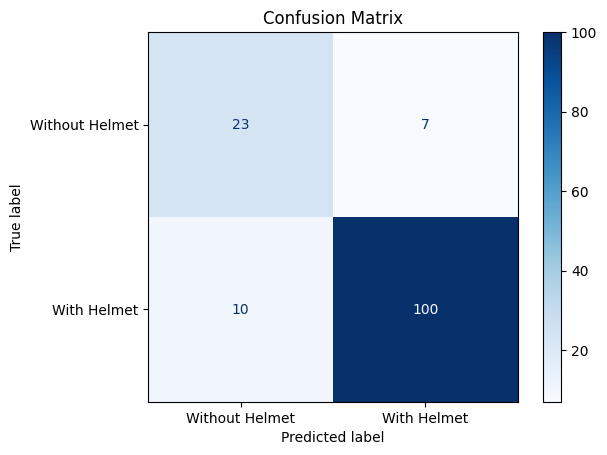

F1 Score: 0.9217


In [117]:
cust_hyper_cnn_rd(85,58,5,0.001,2,0.1,0.25, 32)

In [118]:
print(np.count_nonzero(y_test == 1))
print(np.count_nonzero(y_test == 0))

110
30
